# Walktrough: Cross-Compound Analysis

In this tutorial, we compare the **geometrical space explored during photoinduced dynamics** for related molecular systems: 
- the a Retinal system (**I02**)
- and the compound **I01**, methyleneimmonium ($\mathrm{CH_2NH_2^+}$)

We demonstrate how to **select matching substructures** across different molecules in order to define **comparable, geometry-based descriptors**. These descriptors are then processed and analyzed using **principal component analysis (PCA)** to reduce the dimensionality from six internal coordinates to two, enabling clear and intuitive visualization of the sampled configuration space.

> **Important**: 
> Note, the data of the tutorial is provided as a shnitsel-style NetCDF file for I02 (`./test_data/shnitsel/traj_I02.nc`) and imported from SHARC output files for I01 (`./test_data/sharc/traj_I01_v3.0_triplets/`) to illustrate that we can compare existing datasets to new datasets during analysis.

In [1]:
# from IPython.display import display
import matplotlib.pyplot as plt

import shnitsel as st
import shnitsel.xarray

## 1) Loading and Annotating Molecular Trajectory Data

In the first step, we load the trajectory data of methyleneimmonium (**I01**), retinal (**I02**):

1. Read the trajectory datasets from disk.
2. Clean the inputs to eliminate physically unreasonable data.
3. Merge the data from the different compounds into a common tree that the further analysis will be based on

In [2]:
from shnitsel.clean import sanity_check
from shnitsel.data.tree.support_functions import tree_merge
from pathlib import Path


dt_retinal = st.io.read('test_data/shnitsel/traj_I02.nc')
dt_retinal = sanity_check(dt_retinal)

dt_I01 = st.io.read('./test_data/sharc/traj_I01_v3.0_triplets_nacs_socs/', parallel=False).set_compound_info('I01')
dt_I01 = sanity_check(dt_I01)

mc_tree = tree_merge(dt_retinal, dt_I01)
mc_tree

  0%|          | 0/3 [00:00<?, ?it/s]

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[Trajectory]'> [{'level': 'ShnitselDBRoot', 'children': '2: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 343kB\\nDimensions:              (time: 382, state: 3, atom: 14, direction: 3,\\n                          statecomb: 3, full_statecomb: 6, energy_criterion: 2,\\n                          length_criterion: 2)\\nCoordinates: (12/25)\\n  * time                 (time) float64 3kB 0.0 0.5 1.0 ... 189.5 190.0 190.5\\n  * state                (state) int64 24B 1 2 3\\n  * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13\\n  * direction            (direction) <U1 12B \\\'x\\\' \\\'y\\\' \\\'z\\\'\\n  * statecomb            (statecomb) object 24B MultiIndex\\n  * full_statecomb       (full_statecomb) object 48B MultiIndex\\n    ...                   ...\\n    delta_t              float64 8B 0.5\\n    max_ts               int64 8B 384\\n    t_max                float64 8B 1e+03\\n    charge               float64 8B 1.0\\n    energy_thresholds    (energy_criterion) float64 16B 0.7 1.0\\n    length_thresholds    (length_criterion) float64 16B 3.0 2.0\\nData variables:\\n    energy               (time, state) float32 5kB ...\\n    forces               (time, state, atom, direction) float32 193kB ...\\n    atXYZ                (time, atom, direction) float32 64kB -4.182 ... 3.616\\n    dip_perm             (time, state, direction) float32 14kB ...\\n    dip_trans            (time, statecomb, direction) float32 14kB ...\\n    socs                 (time, full_statecomb) complex128 37kB ...\\n    phases               (time, state) float32 5kB ...\\n    energy_filtranda     (energy_criterion, time) float32 3kB 0.0 0.1572 ... 0.0\\n    length_filtranda     (length_criterion, time) float32 3kB 1.455 ... 1.21\\nAttributes: (12/17)\\n    input_format:           sharc\\n    t_max:                  1000.0\\n    delta_t:                0.5\\n    max_ts:                 384\\n    completed:              False\\n    input_type:             dynamic\\n    ...                     ...\\n    misc_input_settings:    {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"...\\n    trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001\\n    trajid:                 1\\n    DataTree_Level:         TrajectoryData\\n    trajectory_id:          1783740999\\n    __mol:                  <rdkit.Chem.rdchem.Mol object at 0x0000029274C62A70>, _is_multi_trajectory=False), _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nospinorbit\\\'

If we want to, we can inspect individual compounds in the tree by array-style access:

In [3]:
mc_tree['I01']

ABCMeta(_name='I01', _dtype=<class 'shnitsel.data.dataset_containers.trajectory.Trajectory'>, _data=None, _children={'1': ABCMeta(_name=1, _dtype=<class 'shnitsel.data.dataset_containers.trajectory.Trajectory'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 917kB
Dimensions:                 (time: 88, state: 13, atom: 6, direction: 3,
                             statecomb: 78, full_statecomb: 156,
                             energy_criterion: 2, length_criterion: 2)
Coordinates: (12/27)
  * time                    (time) float64 704B 0.0 0.5 1.0 ... 42.5 43.0 43.5
  * state                   (state) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * atom                    (atom) int64 48B 0 1 2 3 4 5
  * direction               (direction) <U1 12B 'x' 'y' 'z'
  * statecomb               (statecomb) object 624B MultiIndex
  * full_statecomb          (full_statecomb) object 1kB MultiIndex
    ...                      ...
    delta_t                 float64 8B 0.5
    max_ts                  int64 8B 90
    t_max                   float64 8B 100.0
    charge                  float64 8B 1.0
    energy_thresholds       (energy_criterion) float64 16B 0.7 1.0
    length_thresholds       (length_criterion) float64 16B 3.0 2.0
Data variables:
    energy                  (time, state) float32 5kB -94.4 -94.06 ... -93.89
    forces                  (time, state, atom, direction) float32 82kB -0.06...
    atXYZ                   (time, atom, direction) float32 6kB -0.005705 ......
    nacs                    (time, statecomb, atom, direction) float32 494kB ...
    dip_perm                (time, state, direction) float32 14kB -0.06869 .....
    dip_trans               (time, statecomb, direction) float32 82kB 0.07728...
    socs                    (time, full_statecomb) complex128 220kB 0j ... -4...
    phases                  (time, state) float32 5kB -1.0 -1.0 -1.0 ... 1.0 1.0
    energy_filtranda        (energy_criterion, time) float32 704B 0.0 ... 0.0
    length_filtranda        (length_criterion, time) float32 704B 1.324 ... 1...
Attributes: (12/15)
    input_format:                 sharc
    _shnitsel_setup_for_cleanup:  True
    completed:                    False
    input_type:                   dynamic
    input_format_version:         3.0
    num_singlets:                 4
    ...                           ...
    theory_basis_set:             cc-pVDZ
    est_level:                    CASSCF
    misc_input_settings:          {'input': {'printlevel': '2', 'geomfile': '...
    trajectory_input_path:        test_data/sharc/traj_I01_v3.0_triplets_nacs...
    trajectory_id:                1
    __mol:                        <rdkit.Chem.rdchem.Mol object at 0x00000292..., _is_multi_trajectory=False), _children={}, _attrs={}, _parent=..., _level_name='DataLeaf'), '2': ABCMeta(_name=2, _dtype=<class 'shnitsel.data.dataset_containers.trajectory.Trajectory'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 327kB
Dimensions:                 (time: 31, state: 13, atom: 6, direction: 3,
                             statecomb: 78, full_statecomb: 156,
                             energy_criterion: 2, length_criterion: 2)
Coordinates: (12/27)
  * time                    (time) float64 248B 0.0 0.5 1.0 ... 14.0 14.5 15.0
  * state                   (state) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * atom                    (atom) int64 48B 0 1 2 3 4 5
  * direction               (direction) <U1 12B 'x' 'y' 'z'
  * statecomb               (statecomb) object 624B MultiIndex
  * full_statecomb          (full_statecomb) object 1kB MultiIndex
    ...                      ...
    delta_t                 float64 8B 0.5
    max_ts                  int64 8B 108
    t_max                   float64 8B 100.0
    charge                  float64 8B 1.0
    energy_thresholds       (energy_criterion) float64 16B 0.7 1.0
    length_thresholds       (length_criterion) float64 16B 3.0 2.0
Data variables:
    energy                  (time, state) float3

## 2) Computing Descriptors for common substructures

In the next step, we **flag a common substructure** that all molecules share, namely the central double bond between an N and a C atom and the adjacent H atoms. This flagging identifies which substructure is considered in the subsequent analysis.

### 2.1) Selecting a substructure

There are two main strategies to select a substructure of interest for further processing:

- provide a SMARTS string that fits the substructure in all compounds
- identify the maximum common substructure automatically

The following example will find the maximum common substructure shared between all compounds within the tree:

In [4]:
from shnitsel.bridges import to_mol
from shnitsel.geo.analogs import extract_analogs
analogs_tree = extract_analogs(mc_tree)
assert analogs_tree is not None

analogs_tree

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[Trajectory]'> [{'level': 'ShnitselDBRoot', 'children': '2: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 178kB\\nDimensions:              (time: 382, state: 3, atom: 5, direction: 3,\\n                          statecomb: 3, full_statecomb: 6, energy_criterion: 2,\\n                          length_criterion: 2)\\nCoordinates: (12/26)\\n  * time                 (time) float64 3kB 0.0 0.5 1.0 ... 189.5 190.0 190.5\\n  * state                (state) int64 24B 1 2 3\\n  * atom                 (atom) int64 40B 0 1 2 3 4\\n  * direction            (direction) <U1 12B \\\'x\\\' \\\'y\\\' \\\'z\\\'\\n  * statecomb            (statecomb) object 24B MultiIndex\\n  * full_statecomb       (full_statecomb) object 48B MultiIndex\\n    ...                   ...\\n    max_ts               int64 8B 384\\n    t_max                float64 8B 1e+03\\n    charge               int64 8B 1\\n    energy_thresholds    (energy_criterion) float64 16B 0.7 1.0\\n    length_thresholds    (length_criterion) float64 16B 3.0 2.0\\n    __mol                object 8B <rdkit.Chem.rdchem.Mol object at 0x0000029...\\nData variables:\\n    energy               (time, state) float32 5kB ...\\n    forces               (time, state, atom, direction) float32 69kB ...\\n    atXYZ                (time, atom, direction) float32 23kB 3.795 ... 1.982\\n    dip_perm             (time, state, direction) float32 14kB ...\\n    dip_trans            (time, statecomb, direction) float32 14kB ...\\n    socs                 (time, full_statecomb) complex128 37kB ...\\n    phases               (time, state) float32 5kB ...\\n    energy_filtranda     (energy_criterion, time) float32 3kB 0.0 0.1572 ... 0.0\\n    length_filtranda     (length_criterion, time) float32 3kB 1.455 ... 1.21\\nAttributes: (12/17)\\n    input_format:           sharc\\n    t_max:                  1000.0\\n    delta_t:                0.5\\n    max_ts:                 384\\n    completed:              False\\n    input_type:             dynamic\\n    ...                     ...\\n    misc_input_settings:    {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"...\\n    trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001\\n    trajid:                 1\\n    DataTree_Level:         TrajectoryData\\n    trajectory_id:          1783740999\\n    __mol:                  <rdkit.Chem.rdchem.Mol object at 0x0000029274E7EA70>, _is_multi_trajectory=False), _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nosp

We can also get a more in-detail look at the substructures identified by the analogs function:

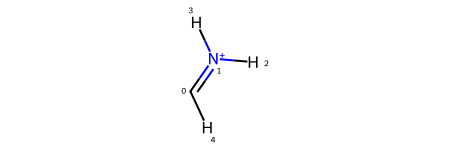

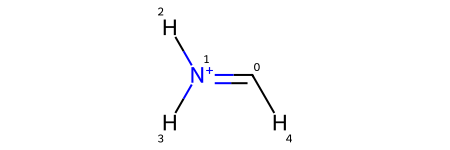

In [5]:
display(analogs_tree['I02/0/data'].mol)
display(analogs_tree['I01/2/data'].mol)

In fact, the matching has found the greatest possible overlap between the two molecules including the charge center around the nitrogen atom, its double bond to a neighboring C atom and the surrounding H atoms.

In the following, we demonstrate how this selection would also have been possible by providing a SMARTS yourself:

In [6]:
from shnitsel.geo.analogs import extract_analogs
smarts_share = '[#6](=[#7](-[#1])-[#1])-[#1]'
tree_smarts_substruct = extract_analogs(mc_tree, smarts=smarts_share)
tree_smarts_substruct

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[Trajectory]'> [{'level': 'ShnitselDBRoot', 'children': '2: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 178kB\\nDimensions:              (time: 382, state: 3, atom: 5, direction: 3,\\n                          statecomb: 3, full_statecomb: 6, energy_criterion: 2,\\n                          length_criterion: 2)\\nCoordinates: (12/26)\\n  * time                 (time) float64 3kB 0.0 0.5 1.0 ... 189.5 190.0 190.5\\n  * state                (state) int64 24B 1 2 3\\n  * atom                 (atom) int64 40B 0 1 2 3 4\\n  * direction            (direction) <U1 12B \\\'x\\\' \\\'y\\\' \\\'z\\\'\\n  * statecomb            (statecomb) object 24B MultiIndex\\n  * full_statecomb       (full_statecomb) object 48B MultiIndex\\n    ...                   ...\\n    max_ts               int64 8B 384\\n    t_max                float64 8B 1e+03\\n    charge               int64 8B 1\\n    energy_thresholds    (energy_criterion) float64 16B 0.7 1.0\\n    length_thresholds    (length_criterion) float64 16B 3.0 2.0\\n    __mol                object 8B <rdkit.Chem.rdchem.Mol object at 0x0000029...\\nData variables:\\n    energy               (time, state) float32 5kB ...\\n    forces               (time, state, atom, direction) float32 69kB ...\\n    atXYZ                (time, atom, direction) float32 23kB 3.795 ... 1.982\\n    dip_perm             (time, state, direction) float32 14kB ...\\n    dip_trans            (time, statecomb, direction) float32 14kB ...\\n    socs                 (time, full_statecomb) complex128 37kB ...\\n    phases               (time, state) float32 5kB ...\\n    energy_filtranda     (energy_criterion, time) float32 3kB 0.0 0.1572 ... 0.0\\n    length_filtranda     (length_criterion, time) float32 3kB 1.455 ... 1.21\\nAttributes: (12/17)\\n    input_format:           sharc\\n    t_max:                  1000.0\\n    delta_t:                0.5\\n    max_ts:                 384\\n    completed:              False\\n    input_type:             dynamic\\n    ...                     ...\\n    misc_input_settings:    {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"...\\n    trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001\\n    trajid:                 1\\n    DataTree_Level:         TrajectoryData\\n    trajectory_id:          1783740999\\n    __mol:                  <rdkit.Chem.rdchem.Mol object at 0x0000029274F9BA60>, _is_multi_trajectory=False), _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nosp

### 2.2) Calculate descriptors

Upon creating the dataset from the matching substructures of all compounds, we can now compute descriptors. Note, the atom numbering was adjusted, so that we can use descriptors that are sensitive to permutation. Since we only searched for 4 atoms in common, the bats, i.e. bonds, angles torsion would only yield 6 descriptors ($3\cdot 4 - 6 = 6$). Similarly, there are 6 pairwise distances in the molecule ($\frac{1}{2}\cdot 4\cdot(4-1) = 6$).

One could apply the seperate functions `subtract_combinations`, `center`, and `norm` to obtain the pairwise distances, subtract the mean and normalize the features. This is also wrapped in a pipeline within the `get_standardized_pairwise_dists` function provided in `shnitsel.analyze.generic`, which we will use in the following. Note, we have to transpose the resulting array, as the PCA requires the data in shape (frames, descriptors).


C:\Users\reshi\git\shnitsel-tools-official\shnitsel\data\traj_combiner_methods.py:491: FutureWarning: In a future version of xarray the default value for compat will change from compat='equals' to compat='override'. This change will result in the following ValueError: Cannot specify both coords='different' and compat='override'. The recommendation is to set compat explicitly for this case.
  frames = xr.concat(


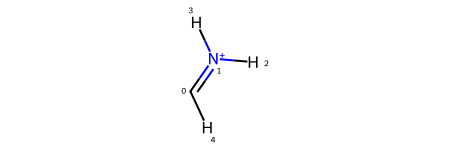

In [7]:
# first we perform PCA over pairwise distances for the whole A03 molecule
from shnitsel.vis.plot import biplot_kde
from shnitsel.analyze.pca import PCA

I02_analog_stacked = analogs_tree["I02"].as_stacked
I02_analog_stacked.mol

In [8]:
from shnitsel.geo.geocalc import get_bats

selection_keys = ['bonds', 'angles', 'dihedrals', 'pyramids']
# Calculate all BATs for all analogs:
dt_analog_bats_all = get_bats(analogs_tree, selection_keys)

# Get the data for just I02 as one dataset
# I02_analog_bats = dt_analog_bats_all["I02"]#.as_stacked
# print(I02_analog_bats)

# Calculate the PCA for I02
pca_res_I02 = PCA(analogs_tree["I02"], structure_selection=selection_keys)

#Since we provided the inputs as a tree, the result is also a tree: 
pca_res_I02


C:\Users\reshi\git\shnitsel-tools-official\shnitsel\data\traj_combiner_methods.py:583: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  frames = xr.concat(framed_da, dim="frame")


ABCMeta(_name='I02', _dtype=<class 'shnitsel.analyze.pca.PCAResult'>, _data=None, _children={'pca': ABCMeta(_name='pca', _dtype=<class 'shnitsel.analyze.pca.PCAResult'>, _data=<shnitsel.analyze.pca.PCAResult object at 0x0000029276A3B5F0>, _children={}, _attrs={}, _parent=..., _level_name='DataLeaf')}, _attrs={'DataTree_Level': 'CompoundGroup', 'compound_info': {'compound_name': 'I02'}}, _parent=None, _level_name='CompoundGroup', _group_info=GroupInfo(group_name="TrajectoryGroupingMetadata(delta_t_in_fs=0.5, input_format_name='sharc', input_format_version='3.0', est_level=None, theory_basis_set=None, charge_in_e=1.0, num_states=3)", group_attributes={'delta_t_in_fs': 0.5, 'input_format_name': 'sharc', 'input_format_version': '3.0', 'est_level': None, 'theory_basis_set': None, 'charge_in_e': 1.0, 'num_states': 3}, grouped_properties=None))

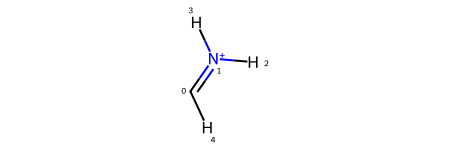

Maximum contributing features overall:
 dih(2,1,0,4) (weight: 0.39314746856689453) (Idxs: (2, 1, 0, 4)) 
 dih(3,1,0,4) (weight: 0.5328256487846375) (Idxs: (3, 1, 0, 4)) 
 dist(0,1) (weight: 0.5414513349533081) (Idxs: (np.int64(0), np.int64(1))) 
 angle(1,0,4) (weight: 0.5417308211326599) (Idxs: (1, 0, 4)) 
 pyr(1,(0,2,3)) (weight: 0.9353851675987244) (Idxs: (1, (0, 2, 3))) 


Maximum contributing features to component 0 :
 angle(2,1,3)  (weight: -0.12271314859390259) (Idxs: (2, 1, 3)) 
 dist(0,1)  (weight: 0.1403745412826538) (Idxs: (np.int64(0), np.int64(1))) 
 dih(2,1,0,4)  (weight: -0.2322111427783966) (Idxs: (2, 1, 0, 4)) 
 dih(3,1,0,4)  (weight: 0.3470216989517212) (Idxs: (3, 1, 0, 4)) 
 pyr(1,(0,2,3))  (weight: 0.882290780544281) (Idxs: (1, (0, 2, 3))) 

Maximum contributing features to component 1 :
 pyr(1,(0,2,3))  (weight: 0.3106580972671509) (Idxs: (1, (0, 2, 3))) 
 dih(2,1,0,4)  (weight: 0.31724268198013306) (Idxs: (2, 1, 0, 4)) 
 dih(3,1,0,4)  (weight: -0.4043254852294922) 

In [9]:
# We can obtain the PCA result: 
pca_res_I02_unwrapped =  pca_res_I02["/pca"].data
# And take a look at the most impactful features identified by PCA:
display(I02_analog_stacked.mol)
print(pca_res_I02_unwrapped.explain_loadings())


C:\Users\reshi\git\shnitsel-tools-official\shnitsel\data\traj_combiner_methods.py:583: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  frames = xr.concat(framed_da, dim="frame")
C:\Users\reshi\git\shnitsel-tools-official\shnitsel\data\traj_combiner_methods.py:583: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  frame

[None, None, None]


[<Figure size 827x389.667 with 6 Axes>]

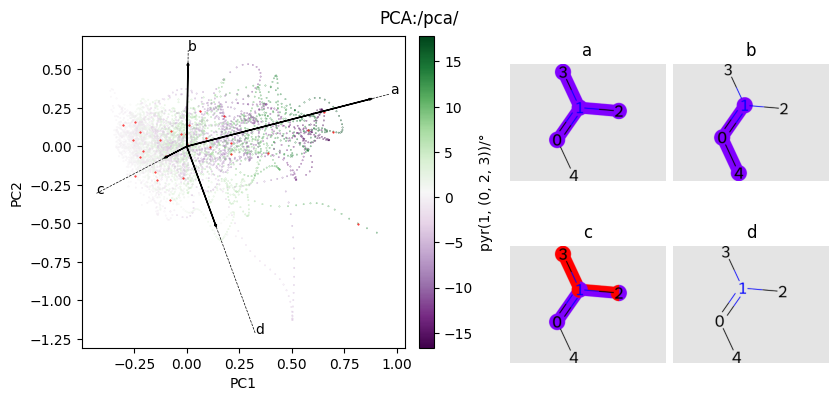

In [10]:
# We can also take a look at the visualized results:
biplot_kde(
    analogs_tree["I02"], 1, (0, 2, 3), pca_data=pca_res_I02, num_bins=4, scatter_color_property="geo"
)

We can now project all geometries onto the pca of 

## 3) Compare Compounds

To visually compare the **geometrical space** explored during the photoinduced dynamics of **A01**, **A02**, **A03**, and **I01**, we use **principal component analysis (PCA)** to reduce the six features to **two dimensions**.

For convenience, we store the PCA results in a `DataArray`. The workflow is as follows:

1. **Initial PCA across all compounds:** We create a temporary `DataArray` where PCA is computed over the combined data of all compounds using `st.analyze.pca.pairwise_dists_pca`. This gives an initial global view of the data in the reduced space.

2. **Reference PCA using A03:** Next, we perform PCA **only on the data for A03**.  

3. **Project the other compounds:** The data for the other compounds (**A01**, **A02**, **I01**) is then **projected onto the principal axes defined by A03**.  

This approach ensures that the PCA axes are consistent with **A03**, while still allowing the other compounds to be compared in the same reduced space.

In [11]:
# perform PCA across all compounds, to create dataset with correct shapes
tmp = st.analyze.pca.pairwise_dists_pca(ds_comb_substruc.atXYZ, mean=True)

# perform PCA only for compound A03
res_pca_a03, pca_obj = shnitsel.analyze.pca.pairwise_dists_pca(ds_comb_substruc.sel(compound='A03').atXYZ, 
                                                               mean=True, return_pca_object=True)

# project all other compounds on PCs of A03
res_pca = pca_obj.transform(pwdists)
ds_pca = tmp.copy(data=res_pca)
ds_pca.sizes

AttributeError: module 'shnitsel.analyze.pca' has no attribute 'pairwise_dists_pca'

In [ ]:
## alternatively one can do that with the accessors via:
#pwdists = ds_comb_substruc.atXYZ.st.pwdists(mean=True)

## perform PCA only for compound A03
#res_pca_a03 = pwdists.sel(compound='A03').st.pca('atomcomb')

## project all other compounds on PCs of A03
#ds_pca = res_pca_a03.st.use_to_transform(pwdists)
#ds_pca.sizes

To illustrate the dynamics of the compounds in PCA space, we first **compute the dihedral angle** and **length of the double bond** of the four atoms relevant for isomerization in butene and store it in the dataset:

In [ ]:
# for plotting purposes we add information on the dihedral angle of the four atoms (defining isomerization for butene)
ds_pca['dih'] = ds_comb_substruc.atXYZ.st.dihedral(0,1,3,5, deg=True)
ds_pca['dist'] = ds_comb_substruc.atXYZ.st.distance(1,3) # C=C distance

Next, we group the dataset by compound and trajectory ID for easier plotting. We then create a subplot mosaic to show each compound separately. For each trajectory, the PCA projections (PC1 *vs* PC2) are plotted in light gray. Finally, the trajectories of each individual compopund are highlighted.

For **A03** color is distinguished based on the final dihedral angle: if < 70° (E-isomer) it is shown in yellow, and if > 110° (Z-isomer) it is shown in blue. 

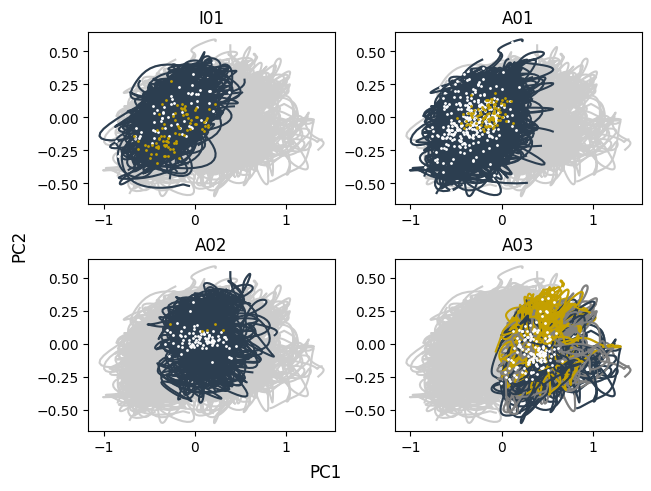

In [ ]:
# group dataset by compounds and trajids
ds_grouped = st.data.multi_indices.mgroupby(ds_pca, ['compound', 'trajid'])

fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')
for name, ax in axs.items():
    ax.set_title(name)
    for (compound, trajid), traj in ds_grouped:
        ax.plot(traj[:,0], traj[:,1], c='#ccc', rasterized=True)

for (compound, trajid), traj in ds_grouped:
    dih_end = traj.dih.values[-1]
    if compound == 'A03':
        c = '#C4A000' if dih_end < 70 else '#2c3e50' if dih_end > 110 else 'gray'
    else:
        c = '#2c3e50'
    axs[compound].plot(traj[:,0], traj[:,1], c=c, rasterized=True)

for compound, trajs in ds_pca.groupby('compound'):
    hops21 = trajs.st.hops('2->1')
    axs[compound].scatter(hops21[:, 0], hops21[:, 1], c='white', s=1, zorder=10, rasterized=True)
    
    if compound=='A03': continue
    hops32 = trajs.st.hops('3->2')
    axs[compound].scatter(hops32[:, 0], hops32[:, 1], c='#C4A000', s=1, zorder=10, rasterized=True)

fig.supxlabel('PC1')
fig.supylabel('PC2')
fig.savefig("/nc/reports/2026-01-13_hop_distributions/PCA_across_compounds_all.pdf", dpi=300)

For comparison, we can also visualize the space spanned by two internal coordinates, e.g. the dihedral angle in the molecule and the length of the central double bond.
These can be e.g. explicitly flagged by smarts and calculated using the `get_bond_torsions` and `get_bond_lengths` functions of the `shnitsel.geo.geocalc` module:

Text(0.02, 0.5, '$\\varphi_{HC=XH}$ / °')

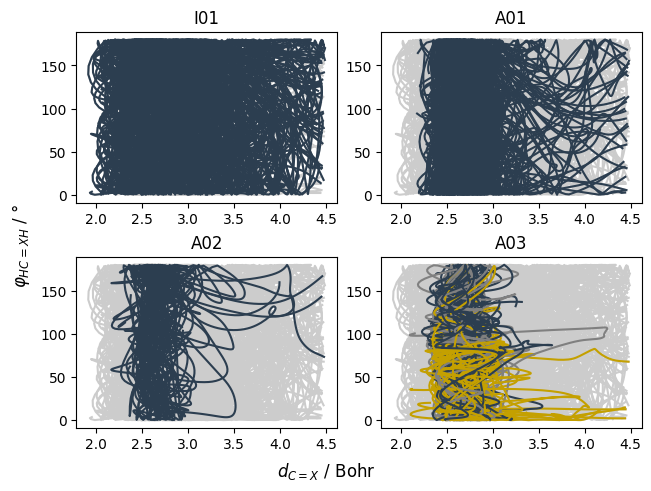

In [ ]:
# group dataset by compounds and trajids
ds_grouped = st.data.multi_indices.mgroupby(ds_pca, ['compound', 'trajid'])

fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')
for name, ax in axs.items():
    ax.set_title(name)
    for (compound, trajid), traj in ds_grouped:
        ax.plot(traj.dist, traj.dih, c='#ccc', rasterized=True)

for (compound, trajid), traj in ds_grouped:
    dih_end = traj['dih'].isel(frame=-1)
    if compound == 'A03':
        c = '#C4A000' if dih_end < 70 else '#2c3e50' if dih_end > 110 else 'gray'
    else:
        c = '#2c3e50'
    axs[compound].plot(traj.dist, traj.dih, c=c, rasterized=True)

fig.supxlabel('$d_{C=X}$ / Bohr')
fig.supylabel('$\\varphi_{HC=XH}$ / °')
#fig.savefig("dist_dih_across_compounds_filtered.pdf", dpi=300)

From the second plot it is easy apparent, that generally C=N bonds can be shorter than C=C bonds and that for all molecules all torsion angles between 0 and 180° are visited, i.e. that there is hydrogen-out-of-plane motion and actualy twisting around the C=C or C=N bond.
